In [1]:
import os

import pandas as pd

import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
timing_dir = '../eval/llm_performance'
files = [os.path.abspath(os.path.join(timing_dir, f)) for f in os.listdir(timing_dir) if ('.json' in f)]
# files

In [3]:
results = []

for file in files:
    with open(file, "r") as f:
        name = file.split("/")[-1].split(".")[0]
        meta_raw = name.split("_imdb_")[1].split("_")
        keys = meta_raw[0::2]
        values = meta_raw[1::2]

        meta = {k: int(v) for k, v in zip(keys, values)}
        
        content = json.loads(f.read())
        prediction = content['children'][0]['children'][0]
        pred_info = prediction['extra_info'].split('|')[1:]
        total = 0
        for i in pred_info:
            kv = i.split(":")
            total += int(kv[1])
            meta[kv[0]] = int(kv[1])
        meta['total'] = total / (1000 * 1000)
        results.append(meta)

results = pd.DataFrame(results)
results.head()

,n,lmt,bs,run,load,move,move_rev,predict,total
0,1000,256,1024,3,787461,1680478,21,101412336,103.880296
1,100,512,64,1,792753,208841,28,26942185,27.943807
2,1000,128,1024,3,783689,1358934,29,43645383,45.788035
3,100,128,4,3,775728,180130,55,2290330,3.246243
4,1000,512,1024,2,774152,1843629,23,280086791,282.704595


## Batch Size vs LLM Max Tokens

#### 100 rows

In [4]:
out = results[results['n'] == 100]
out = out.loc[:, ['bs', 'lmt', 'total']].groupby(['bs', 'lmt']).mean().reset_index()
out = out.pivot(index="bs", columns="lmt", values="total")

<Axes: xlabel='lmt', ylabel='bs'>

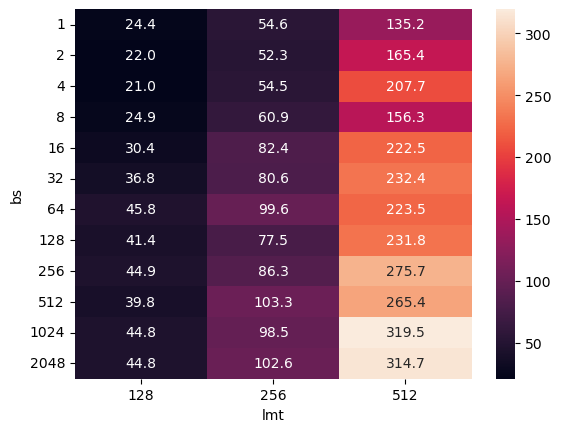

In [11]:
sns.heatmap(data=out, annot=True, fmt=".1f")

#### 1000 rows

In [6]:
out = results[results['n'] == 1000]
out = out.loc[:, ['bs', 'lmt', 'total']].groupby(['bs', 'lmt']).mean().reset_index()
out = out.pivot(index="bs", columns="lmt", values="total")

Text(50.722222222222214, 0.5, 'Batch Size')

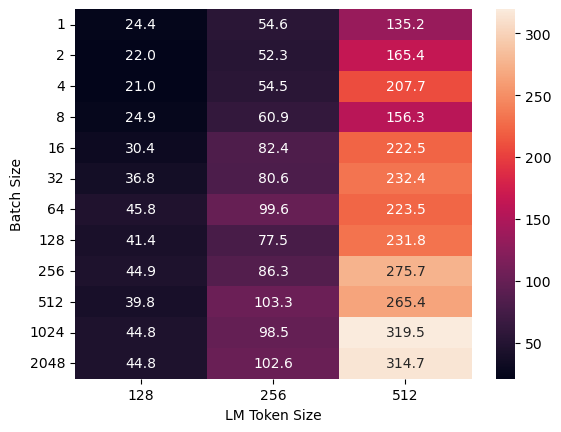

In [13]:
sns.heatmap(data=out, annot=True, fmt=".1f")
plt.xlabel('LM Token Size')
plt.ylabel('Batch Size')

In [17]:
results[(results['n'] == 1000) & (results['lmt'] == 512)].sort_values('total')

,n,lmt,bs,run,load,move,move_rev,predict,total
155,1000,512,1,1,799463,2319547,2497,117655647,120.777154
120,1000,512,1,2,777543,2348685,5172,125496386,128.627786
34,1000,512,2,1,778329,2263005,1190,129462205,132.504729
188,1000,512,8,2,775945,2113766,859,138909429,141.799999
55,1000,512,8,1,786660,2388470,308,147966606,151.142044
205,1000,512,1,3,772586,2560301,4940,152916573,156.254400
26,1000,512,16,3,784791,2100850,604,161476444,164.362689
197,1000,512,8,3,776697,2406371,651,172862635,176.046354
163,1000,512,2,3,783726,2425931,2832,175706634,178.919123
65,1000,512,2,2,776329,2529439,2471,181392112,184.700351
